# Project 2


# Movie Genre Classification

Classify a movie genre based on its plot.

<img src="https://github.com/albahnsen/PracticalMachineLearningClass/raw/master/exercises/moviegenre.png"
     style="float: left; margin-right: 10px;" />




 
  
https://www.kaggle.com/c/miia4200-20191-p2-moviegenreclassification/overview


### Data

Input:
- movie plot

Output:
Probability of the movie belong to each genre


### Evaluation

- 20% API
- 30% Create a solution using with a Machine Learning algorithm - Presentation (5 slides)
- 50% Performance in the Kaggle competition (Normalized acording to class performance in the private leaderboard)


### Acknowledgements

We thank Professor Fabio Gonzalez, Ph.D. and his student John Arevalo for providing this dataset.

See https://arxiv.org/abs/1702.01992

_____

### Owners

The project has been developed by the following:

* Andres Felipe Martinez Tunarroza
* Jorge Luis Medina Herrada
* Ana Milena Rodriguez Gómez
* Nicolas David Gil Quijano

Data Mining. University of the Andes.

April, 2019.

____

# Methodology

In order to develop this project has been proposed the following methodology.

![Notebook_a](https://github.com/afmartinezt/datamining/raw/master/Project/Project%202/images/Notebook_a.png)

The core of the notebook is:

![Notebook_b](https://github.com/afmartinezt/datamining/raw/master/Project/Project%202/images/Notebook_b.png)

In [1]:
import pandas as pd
import os
import numpy as np
import nltk
import time
import string

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import preprocessing
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from num2words import num2words

import seaborn as sns
sns.set(style="darkgrid")

import warnings
warnings.filterwarnings("ignore")

# Extract, Transformation and Load

The ETL process that will follow is:

![Notebook_c](https://github.com/afmartinezt/datamining/raw/master/Project/Project%202/images/Notebook_c.png)
__________

## Extract

In [2]:
dataTraining = pd.read_csv('https://github.com/albahnsen/PracticalMachineLearningClass/raw/master/datasets/dataTraining.zip', encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv('https://github.com/albahnsen/PracticalMachineLearningClass/raw/master/datasets/dataTesting.zip', encoding='UTF-8', index_col=0)

In [3]:
dataTraining.head()

,year,title,plot,genres,rating
3107,2003,Most,most is the story of a single father who takes...,"['Short', 'Drama']",8.0
900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']",5.6
6724,1941,A Woman's Face,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']",7.2
4704,1954,Executive Suite,"in a friday afternoon in new york , the presi...",['Drama'],7.4
2582,1990,Narrow Margin,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']",6.6


In [4]:
dataTesting.head()

,year,title,plot
1,1999,Message in a Bottle,"who meets by fate , shall be sealed by fate ...."
4,1978,Midnight Express,"the true story of billy hayes , an american c..."
5,1996,Primal Fear,martin vail left the chicago da ' s office to ...
6,1950,Crisis,husband and wife americans dr . eugene and mr...
7,1959,The Tingler,the coroner and scientist dr . warren chapin ...


### stop_words

As stopwords has been identified:
* The 10, 15, 20 and 25 most common words in English ([source](https://en.wikipedia.org/wiki/Most_common_words_in_English))
* The 10 most common names in English (USA + UK) for boys and girls ([source](https://www.ef.com/wwen/english-resources/english-names/)) 
* The stop words for `'english'` by `nltk`

In [5]:
# The 10, 15, 20, 25 commons words in English

list_stopwords_10 = {'the','be','to','of','and','a','in','that','have','I','is'}
list_stopwords_15 = {'the','be','to','of','and','a','in','that','have','I','is',
                    'it','for','not','on','with'}
list_stopwords_20 = {'the','be','to','of','and','a','in','that','have','I','is',
                    'it','for','not','on','with','he','as','you','do','at'}
list_stopwords_25 = {'the','be','to','of','and','a','in','that','have','I','is',
                    'it','for','not','on','with','he','as','you','do','at',
                    'this','but','his','by','from'}

# The 10 most common names in English (USA + UK) for boys and girls

stopword_Common_names = {'Oliver','Noah','Jack','Liam','Harry',
                         'Mason','Jacob','Charlie','William','Thomas',
                         'Ethan','George','Michael','Oscar','Alexander',
                         'James','Daniel','Amelia','Emma','Olivia',
                         'Isla','Sophia','Emily','Isabella','Poppy',
                         'Ava','Mia','Isabella','Jessica','Abigail',
                         'Lily','Madison','Sophie','Charlotte'}

# Join the 15 most common words in English + 10 most common names in English (USA + UK) for boys and girls.
# Was choosed the 15 most common words in English because it gave the best performance after trial and erro.

list_stopwords = set.union(stopword_Common_names,list_stopwords_25)

L_stop_words = set(stopwords.words('english'))

stop = set.union(list_stopwords,L_stop_words)

## Transformation
__________

Will be define a function that will *transform* the data from `dataTraining` to be understood and manipulated for the prediction.

Note: Has been used the most common contraction in English to determinate `stop_words` hidden into the text. The common contractions used can be found [here](https://www.ifluentenglish.com/lessonblog/common-contractions)

In [6]:
ids = {'contractions':["' m","' re","' ve","' s","' ll","' d","' n't","'m","'re","'ve","'s","'ll","'d","'n't","[!”#$%&’()*+,-./:;<=>?@[\]^_`{|}~]"],
      'normal':[" am"," are"," have"," is"," will"," had"," not"," am"," are"," have"," is"," will"," had"," not", " "]}

ids = dict(zip(ids['contractions'], ids['normal']))

def PrePros(df):
    
    plot2_ = []
    l_title = []
    l_plot = []
    t_title = []
    t_plot = []
    
    df['plot'].replace(ids, regex=True, inplace=True)
    df['title'].replace(ids, regex=True, inplace=True)
    
    aux = df['title'].astype(str) + " " + df['plot'] + ". "  + df['year'].astype(str)
        
    for i in np.arange(df.shape[0]):
        querywords = pd.DataFrame(aux).iloc[i][0].split()      
        
        resultwords  = [word for word in querywords if word.lower() not in list_stopwords]
        plot2_.append(' '.join(resultwords))

    x_t = pd.DataFrame(plot2_, index=df.index)[0]
    
    #x_y = pd.DataFrame(preprocessing.scale(df['year']), columns=['year'])
    x_y = pd.DataFrame(df['year'], columns=['year'])
    x_y.reset_index(drop=True, inplace=True)
    x_y = x_y.values
    
    x_y_text = dataTraining['year'].apply(num2words)
    
    for i in np.arange(df.shape[0]):
        l_title.append(len(df.iloc[i][1].split()))
        l_plot.append(len(df.iloc[i][2].split()))
        
    #len_title = pd.DataFrame(preprocessing.scale(l_title), columns=['len_title'])
    #len_plot = pd.DataFrame(preprocessing.scale(l_plot), columns=['len_plot'])
    len_title = pd.DataFrame(l_title, columns=['len_title'])
    len_plot = pd.DataFrame(l_plot, columns=['len_plot'])

    x_len_t = len_title['len_title'].values
    x_len_p = len_plot['len_plot'].values
    
    
    for i in np.arange(df.shape[0]):
        t_title.append(len(df.iloc[i][1]))
        t_plot.append(len(df.iloc[i][2]))
        
    #tlen_title = pd.DataFrame(preprocessing.scale(t_title), columns=['len_text_title'])
    #tlen_plot = pd.DataFrame(preprocessing.scale(t_plot), columns=['len_text_plot'])
    tlen_title = pd.DataFrame(t_title, columns=['len_text_title'])
    tlen_plot = pd.DataFrame(t_plot, columns=['len_text_plot'])
    
    x_len_text_t = tlen_title['len_text_title'].values
    x_len_text_p = tlen_plot['len_text_plot'].values
    
    return x_t, x_y, x_len_t, x_len_p, x_len_text_t, x_len_text_p,

Has been created the following new features:

* `X_year`: Year of the movie
* `X_title`: How many words have the title
* `X_plot`: How many words have the plot
* `X_len_title`: How many characters have the title
* `X_len_plot`: How many characters have the plot

In [7]:
X_text, X_year, X_title, X_plot, X_len_title, X_len_plot = PrePros(dataTraining)
pd.DataFrame(X_text).head()

,0
3107,Most most story single father who takes eight ...
900,How Serial Killer serial killer decides teach ...
6724,Woman Face sweden female blackmailer disfiguri...
4704,Executive Suite friday afternoon new york pres...
2582,Narrow Margin los angeles editor publishing ho...


## Load

In order to specify the new `X` and `y` for the Machine Learning - ML models, is necessary to create a *base* case for the NLP algorithms (e.g. `CountVectorizer`).
__________

### Create CountVectorizer (base case)

In [8]:
vect = CountVectorizer()

X_dtm = vect.fit_transform(X_text)
X_dtm.shape

(7895, 39733)

In [9]:
wordnet_lemmatizer = WordNetLemmatizer()

words = list(vect.vocabulary_.keys())[:100]

def split_into_lemmas(text):
    text = text.lower()
    words = text.split()
    return [wordnet_lemmatizer.lemmatize(word) for word in words]

### Create y

In [10]:
dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))

le = MultiLabelBinarizer()
y_genres = le.fit_transform(dataTraining['genres'])

In [11]:
pd.DataFrame(y_genres).head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


Once the `X` and `Y` has been created and specified, will create the **train** and **test** sets for the Machine Learning models in order to predict the gender.

Keep on mind that will be use the same function `train_test_split` across to the whole notebook since will found the best parameters for the Extract Features models `CountVectorizer` and `TfidfVectorizer` and the Machine Learning models as well.

In [12]:
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_dtm, y_genres, test_size=0.3, random_state=42)

# Train multi-class multi-label model

_____

After a brief search, has been found that the models `RandomForestClassifier`, `MultinomialNB` and `XGBClassifier` are widely use on NLP projects. However, was not found on how to use `XGBClassifier` for multi-class multi-label problems so this one has been discard.

The methodology to obtain the best parameters is the following

![Notebook_d](https://github.com/afmartinezt/datamining/raw/master/Project/Project%202/images/Notebook_d.png)


_______


## Extract Features and  Machine Learning Model parameters?

1. ### Random Forest Classifier 

#### Base

In [86]:
clf = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, 
                                                 n_estimators=100, 
                                                 max_depth=10, 
                                                 random_state=42))

clf.fit(X_train, y_train_genres)

OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          n_jobs=None)

In [87]:
y_pred_genres = clf.predict_proba(X_test)

roc_auc_score(y_test_genres, y_pred_genres, average='weighted')

0.8046458785280723

#### Extract Features parameters

What is the best `max_features`? Which other parameters should matters?

In [26]:
Max_F = np.arange(1000,10000,500)

c_mf1 = []
res_vRF = []

for i_Mf in Max_F:
    c_mf1.append(i_Mf)
    
    vect = TfidfVectorizer(max_features = i_Mf, 
                           analyzer = split_into_lemmas, 
                           stop_words = list_stopwords, 
                           ngram_range = (1, 1), 
                           binary = True, 
                           token_pattern = r'\b[a-zA-Z]{3,}\b')
    
    X_dtm = vect.fit_transform(X_text).toarray()
    
    X_def = pd.concat([pd.DataFrame(X_dtm), 
                           pd.DataFrame(X_year), 
                           pd.DataFrame(X_title), 
                           pd.DataFrame(X_plot),
                           pd.DataFrame(X_len_title),
                           pd.DataFrame(X_len_plot)], axis=1)
    
    X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_def, y_genres, test_size=0.3, random_state=42)
    
    clf.fit(X_train, y_train_genres)
    
    y_pred_genres = clf.predict_proba(X_test)
    
    res_vRF.append(roc_auc_score(y_test_genres, y_pred_genres, average='weighted'))
    
    print(str(i_Mf) + ' - ' + str(roc_auc_score(y_test_genres, y_pred_genres, average='weighted')))
    print(time.asctime())

1000 - 0.7861494494848316
Sun Apr 21 17:36:40 2019
1500 - 0.7934185401957979
Sun Apr 21 17:37:33 2019
2000 - 0.7950116166916092
Sun Apr 21 17:38:33 2019
2500 - 0.7975250070622343
Sun Apr 21 17:39:38 2019
3000 - 0.7987383483590941
Sun Apr 21 17:40:52 2019
3500 - 0.7947588384067933
Sun Apr 21 17:42:15 2019
4000 - 0.799349663075241
Sun Apr 21 17:43:46 2019
4500 - 0.8006031306582942
Sun Apr 21 17:45:23 2019
5000 - 0.802674806216992
Sun Apr 21 17:47:06 2019
5500 - 0.801929727741973
Sun Apr 21 17:48:55 2019
6000 - 0.804127478614134
Sun Apr 21 17:51:09 2019
6500 - 0.8046458785280723
Sun Apr 21 17:53:24 2019
7000 - 0.8015096253183684
Sun Apr 21 17:55:43 2019
7500 - 0.8028256809504958
Sun Apr 21 17:58:07 2019
8000 - 0.8015663140246998
Sun Apr 21 18:00:36 2019
8500 - 0.8031021449532593
Sun Apr 21 18:03:02 2019
9000 - 0.8043203220463682
Sun Apr 21 18:05:37 2019
9500 - 0.8038294122663036
Sun Apr 21 18:08:17 2019


In [27]:
Results_1 = pd.DataFrame()
Results_1 = pd.concat([pd.DataFrame(c_mf1, columns=['max_features']),
                       pd.DataFrame(res_vRF, columns=['roc_auc_score'])], axis=1)

Results_1.head()

,max_features,roc_auc_score
0,1000,0.786149
1,1500,0.793419
2,2000,0.795012
3,2500,0.797525
4,3000,0.798738


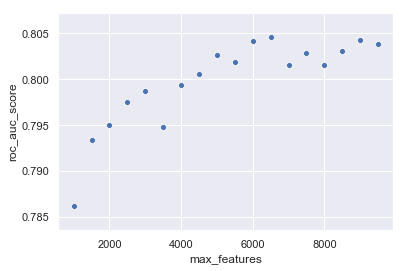

In [28]:
sns.scatterplot(x="max_features", y="roc_auc_score", data=Results_1)

In [29]:
Results_1.sort_values(by=['roc_auc_score'], inplace=True, ascending=False)
Results_1.head()

,max_features,roc_auc_score
11,6500,0.804646
16,9000,0.804320
10,6000,0.804127
17,9500,0.803829
15,8500,0.803102


#### Machine Learning parameters

Will be found the best parameters for the `RandomForestClassifier` using the **train** set that will gives the best performance.

In [77]:
vect = TfidfVectorizer(max_features = 6500, 
                       analyzer = split_into_lemmas, 
                       stop_words = list_stopwords, 
                       ngram_range = (1, 1), 
                       binary = True, 
                       token_pattern = r'\b[a-zA-Z]{3,}\b')
    
X_dtm = vect.fit_transform(X_text).toarray()
    
X_def = pd.concat([pd.DataFrame(X_dtm), 
                   pd.DataFrame(X_year), 
                   pd.DataFrame(X_title), 
                   pd.DataFrame(X_plot),
                   pd.DataFrame(X_len_title),
                   pd.DataFrame(X_len_plot)], axis=1)
    
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_def, y_genres, test_size=0.3, random_state=42)

In [73]:
N_Est = np.arange(300, 800, 100)
M_Dep = np.arange(10, 60, 20)
M_Feat = np.arange(10, 60, 20)

c_ne_ML = []
c_md_ML = []
c_mf_ML = []

res_vRF_ = []

for i_Ne in N_Est:
    for i_Md in M_Dep:
        for i_Mf in M_Feat:
            
            c_ne_ML.append(i_Ne)
            c_md_ML.append(i_Md)
            c_mf_ML.append(i_Mf)
            
            clf1 = OneVsRestClassifier(RandomForestClassifier(n_jobs = -1, 
                                                             n_estimators = i_Ne, 
                                                             max_depth = i_Md, 
                                                             max_features = i_Mf,
                                                             random_state = 42))
            
            
            clf1.fit(X_train, y_train_genres)
    
            y_pred_genres = clf1.predict_proba(X_test)
    
            res_vRF_.append(roc_auc_score(y_test_genres, y_pred_genres, average='weighted'))
    
            print(str(i_Ne) + ' - ' + str(i_Md) + ' - ' + str(i_Mf) + ' - ' + str(roc_auc_score(y_test_genres, y_pred_genres, average='weighted')))
            print(time.asctime())

300 - 10 - 10 - 0.8168109103352253
Sun Apr 21 18:45:52 2019
300 - 10 - 30 - 0.8218778151384833
Sun Apr 21 18:49:02 2019
300 - 10 - 50 - 0.8175461876443406
Sun Apr 21 18:53:32 2019
300 - 30 - 10 - 0.8262278335119418
Sun Apr 21 18:56:30 2019
300 - 30 - 30 - 0.8237542458883538
Sun Apr 21 19:02:37 2019
300 - 30 - 50 - 0.8201301011925793
Sun Apr 21 19:11:07 2019
300 - 50 - 10 - 0.8265213839818374
Sun Apr 21 19:14:58 2019
300 - 50 - 30 - 0.8200860884817073
Sun Apr 21 19:21:46 2019
300 - 50 - 50 - 0.8181166167309525
Sun Apr 21 19:31:11 2019
400 - 10 - 10 - 0.8223736326618309
Sun Apr 21 19:33:07 2019
400 - 10 - 30 - 0.8233298176869106
Sun Apr 21 19:36:35 2019
400 - 10 - 50 - 0.8195962594593215
Sun Apr 21 19:41:54 2019
400 - 30 - 10 - 0.8299866985090296
Sun Apr 21 19:45:21 2019
400 - 30 - 30 - 0.8246814849393741
Sun Apr 21 19:52:29 2019
400 - 30 - 50 - 0.821672600080777
Sun Apr 21 20:02:19 2019
400 - 50 - 10 - 0.8294558804148436
Sun Apr 21 20:07:03 2019
400 - 50 - 30 - 0.8222928539037533
Sun Ap

In [74]:
Results_3 = pd.DataFrame()
Results_3 = pd.concat([pd.DataFrame(c_ne_ML, columns=['n_estimators']),
                       pd.DataFrame(c_md_ML, columns=['max_depth']),
                       pd.DataFrame(c_mf_ML, columns=['max_features']),
                       pd.DataFrame(res_vRF_, columns=['roc_auc_score'])], axis=1)

Results_3.head()

,n_estimators,max_depth,max_features,roc_auc_score
0,300,10,10,0.816811
1,300,10,30,0.821878
2,300,10,50,0.817546
3,300,30,10,0.826228
4,300,30,30,0.823754


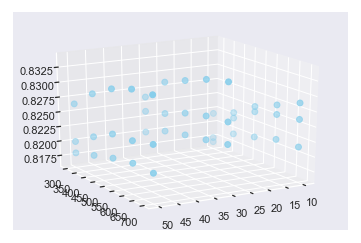

In [82]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Results_3['max_depth'], Results_3['n_estimators'], Results_3['roc_auc_score'], c='skyblue', s=35)
ax.view_init(20, 60)

In [76]:
Results_3.sort_values(by=['roc_auc_score'], inplace=True, ascending=False)
Results_3.head()

,n_estimators,max_depth,max_features,roc_auc_score
39,700,30,10,0.833628
42,700,50,10,0.833030
30,600,30,10,0.832821
33,600,50,10,0.832676
24,500,50,10,0.831495


#### Consolidation

In [83]:
vect = TfidfVectorizer(max_features = 6500, 
                       analyzer = split_into_lemmas, 
                       stop_words = list_stopwords, 
                       ngram_range = (1, 1), 
                       binary = True, 
                       token_pattern = r'\b[a-zA-Z]{3,}\b')

X_dtm = vect.fit_transform(X_text).toarray()

X_def = pd.concat([pd.DataFrame(X_dtm), 
                   pd.DataFrame(X_year, columns={'year'}), 
                   pd.DataFrame(X_title, columns={'Length_words_title'}), 
                   pd.DataFrame(X_plot, columns={'Length_words_plot'}),
                   pd.DataFrame(X_len_title, columns={'Length_title'}),
                   pd.DataFrame(X_len_plot, columns={'Length_title'})], axis=1)

X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_def, y_genres, test_size=0.3, random_state=42)

X_def.head()

,0,1,2,3,4,5,6,7,8,9,...,6495,6496,6497,6498,6499,year,Length_words_title,Length_words_plot,Length_title,Length_title
0,0.000000,0.0,0.0,0.022480,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2003,1,222,4,1236
1,0.000000,0.0,0.0,0.065073,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2008,6,17,25,94
2,0.000000,0.0,0.0,0.028273,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1941,4,124,15,737
3,0.042194,0.0,0.0,0.016436,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1954,2,350,15,2067
4,0.000000,0.0,0.0,0.024171,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1990,2,179,13,1027


In [84]:
clf = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1,
                                                 n_estimators = 700, 
                                                 max_depth = 30, 
                                                 max_features = 10,
                                                 random_state=42))

clf.fit(X_train, y_train_genres)

OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=700, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          n_jobs=None)

In [85]:
y_pred_genres = clf.predict_proba(X_test)

roc_auc_score(y_test_genres, y_pred_genres, average='weighted')

0.8251754268369469

2. ### Multinomial Naive Bayes Classifier  

#### Base

In [88]:
mnb = OneVsRestClassifier(MultinomialNB(fit_prior=True, class_prior=None))

mnb.fit(X_train, y_train_genres)

OneVsRestClassifier(estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
          n_jobs=None)

In [89]:
y_pred_genres = mnb.predict_proba(X_test)

roc_auc_score(y_test_genres, y_pred_genres, average='weighted')

0.5672143126069444

#### Extract Features parameters

In [44]:
Max_F = np.arange(1000,10000,500)

c_mf2 = []
res_vMNB = []

for i_Mf in Max_F:
    c_mf2.append(i_Mf)
    
    vect = CountVectorizer(max_features = i_Mf, 
                           analyzer = split_into_lemmas, 
                           stop_words = list_stopwords, 
                           ngram_range = (1, 1), 
                           binary = True, 
                           token_pattern = r'\b[a-zA-Z]{3,}\b')
    
    X_dtm = vect.fit_transform(X_text).toarray()
    
    X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_dtm, y_genres, test_size=0.3, random_state=42)
    
    mnb.fit(X_train, y_train_genres)
    
    y_pred_genres = mnb.predict_proba(X_test)
    
    res_vMNB.append(roc_auc_score(y_test_genres, y_pred_genres, average='weighted'))
    
    print(str(i_Mf) + ' - ' + str(roc_auc_score(y_test_genres, y_pred_genres, average='weighted')))
    print(time.asctime())

1000 - 0.8227098443536744
Sun Apr 21 18:26:34 2019
1500 - 0.8308280810520191
Sun Apr 21 18:26:44 2019
2000 - 0.8338378238187345
Sun Apr 21 18:26:55 2019
2500 - 0.8367556632170984
Sun Apr 21 18:27:08 2019
3000 - 0.8394130422235423
Sun Apr 21 18:27:21 2019
3500 - 0.840221690743519
Sun Apr 21 18:27:36 2019
4000 - 0.8410723231013795
Sun Apr 21 18:27:52 2019
4500 - 0.8423480077757077
Sun Apr 21 18:28:10 2019
5000 - 0.8426939133336001
Sun Apr 21 18:28:29 2019
5500 - 0.842303808090339
Sun Apr 21 18:28:49 2019
6000 - 0.841833160053369
Sun Apr 21 18:29:11 2019
6500 - 0.8419620443222076
Sun Apr 21 18:29:34 2019
7000 - 0.8414334912868272
Sun Apr 21 18:29:58 2019
7500 - 0.841099312481593
Sun Apr 21 18:30:23 2019
8000 - 0.8406366922174681
Sun Apr 21 18:30:51 2019
8500 - 0.8400336512930638
Sun Apr 21 18:31:17 2019
9000 - 0.8383175223542205
Sun Apr 21 18:31:45 2019
9500 - 0.8371023628058096
Sun Apr 21 18:32:05 2019


In [45]:
Results_2 = pd.DataFrame()
Results_2 = pd.concat([pd.DataFrame(c_mf2, columns=['max_features']),
                       pd.DataFrame(res_vMNB, columns=['roc_auc_score'])], axis=1)

Results_2.head()

,max_features,roc_auc_score
0,1000,0.822710
1,1500,0.830828
2,2000,0.833838
3,2500,0.836756
4,3000,0.839413


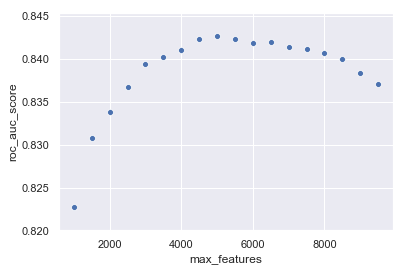

In [46]:
sns.scatterplot(x="max_features", y="roc_auc_score", data=Results_2)

In [47]:
Results_2.sort_values(by=['roc_auc_score'], inplace=True, ascending=False)
Results_2.head()

,max_features,roc_auc_score
8,5000,0.842694
7,4500,0.842348
9,5500,0.842304
11,6500,0.841962
10,6000,0.841833


Let's search on the range [4500 - 5200] if there is something interesting...

In [49]:
Max_F = np.arange(4500,5200,50)

c_mf2 = []
res_vMNB = []

for i_Mf in Max_F:
    c_mf2.append(i_Mf)
    
    vect = CountVectorizer(max_features = i_Mf, 
                           analyzer = split_into_lemmas, 
                           stop_words = list_stopwords, 
                           ngram_range = (1, 1), 
                           binary = True, 
                           token_pattern = r'\b[a-zA-Z]{3,}\b')
    
    X_dtm = vect.fit_transform(X_text).toarray()
    
    X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_dtm, y_genres, test_size=0.3, random_state=42)
    
    mnb.fit(X_train, y_train_genres)
    
    y_pred_genres = mnb.predict_proba(X_test)
    
    res_vMNB.append(roc_auc_score(y_test_genres, y_pred_genres, average='weighted'))
    
    print(str(i_Mf) + ' - ' + str(roc_auc_score(y_test_genres, y_pred_genres, average='weighted')))
    print(time.asctime())

4500 - 0.8423480077757077
Sun Apr 21 18:33:51 2019
4550 - 0.8422795320485087
Sun Apr 21 18:34:03 2019
4600 - 0.842068460612153
Sun Apr 21 18:34:15 2019
4650 - 0.8421486292459407
Sun Apr 21 18:34:27 2019
4700 - 0.8424345112803608
Sun Apr 21 18:34:39 2019
4750 - 0.8422433005582513
Sun Apr 21 18:34:51 2019
4800 - 0.8422632577528928
Sun Apr 21 18:35:03 2019
4850 - 0.8425098157811348
Sun Apr 21 18:35:15 2019
4900 - 0.8426282706478327
Sun Apr 21 18:35:26 2019
4950 - 0.8427529492724583
Sun Apr 21 18:35:38 2019
5000 - 0.8426939133336001
Sun Apr 21 18:35:50 2019
5050 - 0.8427985089982534
Sun Apr 21 18:36:02 2019
5100 - 0.8426395462940982
Sun Apr 21 18:36:14 2019
5150 - 0.8425756491392836
Sun Apr 21 18:36:26 2019


In [50]:
Results_2_ = pd.DataFrame()
Results_2_ = pd.concat([pd.DataFrame(c_mf2, columns=['max_features']),
                       pd.DataFrame(res_vMNB, columns=['roc_auc_score'])], axis=1)

Results_2_.head()

,max_features,roc_auc_score
0,4500,0.842348
1,4550,0.842280
2,4600,0.842068
3,4650,0.842149
4,4700,0.842435


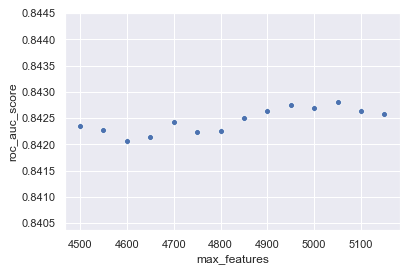

In [51]:
sns.scatterplot(x="max_features", y="roc_auc_score", data=Results_2_)

In [52]:
Results_2_.sort_values(by=['roc_auc_score'], inplace=True, ascending=False)
Results_2_.head()

,max_features,roc_auc_score
11,5050,0.842799
9,4950,0.842753
10,5000,0.842694
12,5100,0.842640
8,4900,0.842628


#### Consolidation

In [56]:
vect_ = CountVectorizer(max_features=5050, 
                        analyzer = split_into_lemmas, 
                        stop_words=list_stopwords, 
                        ngram_range=(1, 1), 
                        binary=True,
                        token_pattern = r'\b[a-zA-Z]{3,}\b') # Palabras con 3 o más caracteres

X_dtm = vect_.fit_transform(X_text).toarray()

X_def = pd.concat([pd.DataFrame(X_dtm), 
                   pd.DataFrame(X_year, columns={'year'}), 
                   pd.DataFrame(X_title, columns={'Length_words_title'}), 
                   pd.DataFrame(X_plot, columns={'Length_words_plot'}),
                   pd.DataFrame(X_len_title, columns={'Length_title'}),
                   pd.DataFrame(X_len_plot, columns={'Length_title'})], axis=1)

X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_dtm, y_genres, test_size=0.3, random_state=42)

X_def.head()

,0,1,2,3,4,5,6,7,8,9,...,5045,5046,5047,5048,5049,year,Length_words_title,Length_words_plot,Length_title,Length_title
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,2003,1,222,4,1236
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,2008,6,17,25,94
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1941,4,124,15,737
3,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1954,2,350,15,2067
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1990,2,179,13,1027


In [57]:
mnb = OneVsRestClassifier(MultinomialNB(fit_prior=True, class_prior=None))

mnb.fit(X_train, y_train_genres)

OneVsRestClassifier(estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
          n_jobs=None)

In [58]:
y_pred_genres = mnb.predict_proba(X_test)

roc_auc_score(y_test_genres, y_pred_genres, average='weighted')

0.8427985089982534

## Model for Kaggle competition
____

![Notebook_de](https://github.com/afmartinezt/datamining/raw/master/Project/Project%202/images/Notebook_de.png)

From the work made above, has been determinated that `CountVectorizer` and `MultinomialNB` gives the best parameters.

Keep on mind that the artificial features created `X_year`, `X_title`, `X_plot`, `X_len_title`, `X_len_plot` were not useful for the `MultinomialNB` models, but it was for the `RandomForestClassifier`.

In [66]:
vect_ = CountVectorizer(max_features=5050, 
                        analyzer = split_into_lemmas, 
                        stop_words=list_stopwords, 
                        ngram_range=(1, 1), 
                        binary=True,
                        token_pattern = r'\b[a-zA-Z]{3,}\b') # Palabras con 3 o más caracteres

X_dtm = vect_.fit_transform(X_text).toarray()

X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_dtm, y_genres, test_size=0.3, random_state=42)

X_def.head()

,0,1,2,3,4,5,6,7,8,9,...,5045,5046,5047,5048,5049,year,Length_words_title,Length_words_plot,Length_title,Length_title
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,2003,1,222,4,1236
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,2008,6,17,25,94
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1941,4,124,15,737
3,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1954,2,350,15,2067
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1990,2,179,13,1027


In [67]:
mnb = OneVsRestClassifier(MultinomialNB(fit_prior=True, class_prior=None))

mnb.fit(X_train, y_train_genres)

OneVsRestClassifier(estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
          n_jobs=None)

In [68]:
y_pred_genres = mnb.predict_proba(X_test)

roc_auc_score(y_test_genres, y_pred_genres, average='weighted')

0.8427985089982534

### Predict the testing dataset

In [69]:
X_test_text, X_test_year, X_test_title, X_test_plot, X_test_len_title, X_test_len_plot = PrePros(dataTesting)

X_test_dtm = vect_.transform(X_test_text).toarray()

X_test_def = pd.concat([pd.DataFrame(X_test_dtm), 
                        pd.DataFrame(X_test_year, columns={'year'}), 
                        pd.DataFrame(X_test_title, columns={'Length_words_title'}), 
                        pd.DataFrame(X_test_plot, columns={'Length_words_plot'}), 
                        pd.DataFrame(X_test_len_title, columns={'Length_title'}), 
                        pd.DataFrame(X_test_len_plot, columns={'Length_title'})], axis=1)

cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

y_pred_test_genres = mnb.predict_proba(X_test_dtm)

In [70]:
res = pd.DataFrame(y_pred_test_genres, index=dataTesting.index, columns=cols)

In [71]:
res.head()

,p_Action,p_Adventure,p_Animation,p_Biography,p_Comedy,p_Crime,p_Documentary,p_Drama,p_Family,p_Fantasy,...,p_Musical,p_Mystery,p_News,p_Romance,p_Sci-Fi,p_Short,p_Sport,p_Thriller,p_War,p_Western
1,2.093652e-04,5.141012e-03,4.409642e-07,4.515122e-08,7.811905e-01,0.001704,6.313294e-13,0.811848,4.799531e-03,3.371158e-01,...,7.009556e-04,0.005750,4.360010e-31,0.992937,8.707612e-06,1.267059e-14,6.478002e-07,0.035630,1.189119e-09,1.599827e-07
4,1.126292e-01,1.372018e-03,4.486659e-05,7.775508e-02,7.858470e-02,0.822101,5.339221e-04,0.807466,4.061437e-04,5.958376e-04,...,7.897390e-04,0.003787,1.234394e-17,0.003794,1.486471e-04,1.828332e-06,4.523698e-03,0.188024,2.301191e-04,8.576826e-04
5,2.880406e-13,1.239194e-20,5.316891e-28,2.051697e-08,1.153521e-06,0.999999,2.537785e-21,1.000000,1.950097e-22,2.119185e-17,...,1.106911e-14,0.996211,2.088598e-66,0.003989,3.821954e-15,5.671744e-35,1.443994e-16,0.996218,1.177571e-15,1.046712e-20
6,6.325580e-05,9.996001e-06,1.521799e-14,1.396457e-08,1.768132e-04,0.000163,1.469937e-15,0.999985,7.525627e-10,5.730676e-08,...,1.465882e-06,0.000042,7.600275e-48,0.034569,8.389391e-06,4.618284e-21,9.242944e-11,0.245252,1.819847e-02,1.866729e-07
7,5.841245e-05,6.596320e-05,1.379015e-03,1.219909e-03,6.734216e-07,0.032572,5.879533e-08,0.000166,8.282531e-04,8.838311e-01,...,3.327224e-06,0.176133,2.150610e-23,0.000005,9.999960e-01,1.018354e-05,4.450862e-11,0.889727,3.174962e-09,4.505947e-06


In [72]:
res.to_csv('pred_genres_text_RF.csv', index_label='ID')

# API

_________

Has been created the API for the project developed above. This API is hosted in Amazon Web Services (AWS).

The API can be accessed through the following IP address: http://3.17.11.198:8088/ 

**Screenshots of the API:**

![API_1](https://github.com/afmartinezt/datamining/raw/master/Project/Project%202/images/API_1.png)
![API_2](https://github.com/afmartinezt/datamining/raw/master/Project/Project%202/images/API_2.png)
![API_3](https://github.com/afmartinezt/datamining/raw/master/Project/Project%202/images/API_3.png)